In [1]:
import os
import pandas as pd
import torch

import importlib
import pickle
import re

base_path = os.getcwd()
data_path = os.path.join(base_path, "data")
question_path = os.path.join(data_path, "questions")
python_path = os.path.join(data_path, "python")

In [3]:
import ProblemSetReader
importlib.reload(ProblemSetReader)
problem_set_reader = ProblemSetReader.ProblemSetReader()
df = pd.read_pickle("./data/euler_df.pkl")

In [4]:
print(df.shape)
df

(58, 4)


,idx,question,answer,python_code
0,1,If we list all the natural numbers below $10$ ...,2.331680e+05,\n\ndef compute():\n\tans = sum(x for x in ran...
1,2,Each new term in the Fibonacci sequence is gen...,4.613732e+06,\n\ndef compute():\n\tans = 0\n\tx = 1 # Repr...
2,3,"The prime factors of $13195$ are $5, 7, 13$ an...",6.857000e+03,\nimport math\n\n\ndef compute():\n\tn = 60085...
3,4,A palindromic number reads the same both ways....,9.066090e+05,\n\ndef compute():\n\tans = max(i * j\n\t\tfor...
4,5,$2520$ is the smallest number that can be divi...,2.327926e+08,\nimport math\n\n\ndef compute():\n\tans = mat...
5,6,The sum of the squares of the first ten natura...,2.516415e+07,\n\ndef compute():\n\tN = 100\n\ts = sum(i for...
6,7,"By listing the first six prime numbers: $2, 3,...",1.047430e+05,"\nimport eulerlib, itertools\n\n\ndef compute(..."
7,9,A Pythagorean triplet is a set of three natura...,3.187500e+07,\n\ndef compute():\n\tPERIMETER = 1000\n\tfor ...
8,10,The sum of the primes below $10$ is $2 + 3 + 5...,1.429138e+11,\nimport eulerlib\n\n\ndef compute():\n\tans =...
9,15,Starting in the top left corner of a $2 \times...,1.378465e+11,\nimport math\n\n\ndef compute():\n\treturn st...


# Test GPT

In [5]:
import GPTAgent
importlib.reload(GPTAgent)
gpt_agent = GPTAgent.GPTAgent()

In [6]:
response_string = gpt_agent.generate_chain_of_thoughts(problem_set_reader.get_question(125))
procedures = response_string.split("\n")
procedures

AssertionError: 

In [ ]:
from g4f.client import Client

client = Client()
response = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "system", "content": "Only respond in English."},
              {"role": "user", "content": "How to make a cup of tea?"}, 
              {"role": "assistant", "content": "Simply boil water and add tea."}, 
              {"role": "user", "content": "What is the last question I asked you?"}],
)
response.choices[0].message.content

"I'm sorry, but I don't have the ability to recall past interactions or questions from previous conversations. Each session with me is independent, and I treat every interaction as a new encounter. How may I assist you today?\n"

In [ ]:
messages = []

for step_description in procedures:
    prompt = f"Generate at most two line of python code (packed by ```python {{python_code}}```) for this step (and only this step): {step_description}. \
        Directly output the code without explaination, output space to indent if necessary"

    messages.append({"role": "user", "content": prompt})
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )
    ret_string = response.choices[0].message.content
    print(ret_string)
    messages.append({"role": "assistant", "content": ret_string})

```
python
problem_statement = input("请输入问题描述：")
required_input_output = input("请输入所需输入输出：")
```
```python
for i in range(1, 10**8 + 1):
    if str(i) == str(i)[::-1]:
        print(i)
```
```python
import itertools
for i in range(1, 10**8 + 1):
    if str(i) == str(i)[::-1]:
        for r in range(1, int(i**0.5) + 1):
            for combo in itertools.combinations(range(1, r + 1), r):
                if sum(j**2 for j in combo) == i:
                    print(f"{i} = {'+'.join(str(j**2) for j in combo)}")
```
```python
for i in range(1, 10**8 + 1):
    if str(i) == str(i)[::-1] and i!= 2 and any(sum(j**2 for j in range(a, b)) == i for a in range(1, int(i**0.5) + 1) for b in range(a, int(i**0.5) + 2)):
        print(i)
```
```python
sum_of_palindromes = sum(i for i in range(1, 10**8 + 1) if str(i) == str(i)[::-1] and any(sum(j**2 for j in range(a, b)) == i for a in range(1, int(i**0.5) + 1) for b in range(a, int(i**0.5) + 2)) and i != 1)
print(sum_of_palindromes)
```


In [ ]:
raw_code = [messages['content'] for messages in messages if messages['role']=='assistant']
raw_code

['```\npython\nproblem_statement = input("请输入问题描述：")\nrequired_input_output = input("请输入所需输入输出：")\n```',
 '```python\nfor i in range(1, 10**8 + 1):\n    if str(i) == str(i)[::-1]:\n        print(i)\n```',
 '```python\nimport itertools\nfor i in range(1, 10**8 + 1):\n    if str(i) == str(i)[::-1]:\n        for r in range(1, int(i**0.5) + 1):\n            for combo in itertools.combinations(range(1, r + 1), r):\n                if sum(j**2 for j in combo) == i:\n                    print(f"{i} = {\'+\'.join(str(j**2) for j in combo)}")\n```',
 '```python\nfor i in range(1, 10**8 + 1):\n    if str(i) == str(i)[::-1] and i!= 2 and any(sum(j**2 for j in range(a, b)) == i for a in range(1, int(i**0.5) + 1) for b in range(a, int(i**0.5) + 2)):\n        print(i)\n```',
 '```python\nsum_of_palindromes = sum(i for i in range(1, 10**8 + 1) if str(i) == str(i)[::-1] and any(sum(j**2 for j in range(a, b)) == i for a in range(1, int(i**0.5) + 1) for b in range(a, int(i**0.5) + 2)) and i != 1)\nprint

In [ ]:
pattern = r"```python(.*?)```"
code_cleansed = [match.group(1) for match in re.finditer(pattern, '\n'.join(raw_code), re.DOTALL)]
code_concat = "".join(code_cleansed)
print(code_concat)


for i in range(1, 10**8 + 1):
    if str(i) == str(i)[::-1]:
        print(i)

import itertools
for i in range(1, 10**8 + 1):
    if str(i) == str(i)[::-1]:
        for r in range(1, int(i**0.5) + 1):
            for combo in itertools.combinations(range(1, r + 1), r):
                if sum(j**2 for j in combo) == i:
                    print(f"{i} = {'+'.join(str(j**2) for j in combo)}")

for i in range(1, 10**8 + 1):
    if str(i) == str(i)[::-1] and i!= 2 and any(sum(j**2 for j in range(a, b)) == i for a in range(1, int(i**0.5) + 1) for b in range(a, int(i**0.5) + 2)):
        print(i)

sum_of_palindromes = sum(i for i in range(1, 10**8 + 1) if str(i) == str(i)[::-1] and any(sum(j**2 for j in range(a, b)) == i for a in range(1, int(i**0.5) + 1) for b in range(a, int(i**0.5) + 2)) and i != 1)
print(sum_of_palindromes)



# Token Number Test

In [7]:
import CodeGenAgent
importlib.reload(CodeGenAgent)
codegen_agent = CodeGenAgent.CodeGenAgent()

c:\ProgramData\anaconda3\envs\default\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/206 [00:00<?, ?it/s]

100%|██████████| 206/206 [00:01<00:00, 106.62it/s]


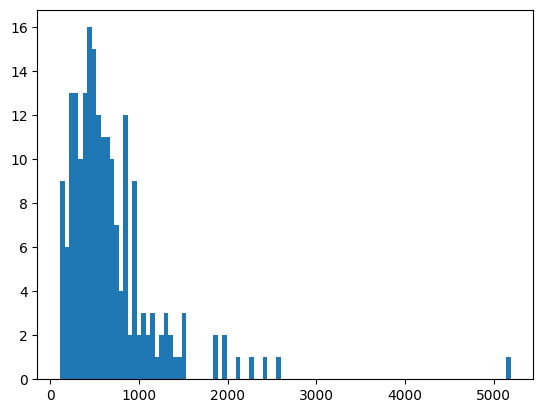

In [8]:
import tqdm
lengths = []
token_count = []
for ques_doc in tqdm.tqdm(os.listdir(question_path)):
    if not ques_doc.endswith(".txt"): continue
    question = open(os.path.join(question_path, ques_doc)).read()
    lengths.append(len(question))

    token_out = codegen_agent.tokenizer(question, return_tensors="pt")
    token_count.append(token_out["input_ids"].shape[1])


# Draw histogram
import matplotlib.pyplot as plt
plt.hist(lengths, bins=100)
plt.show()

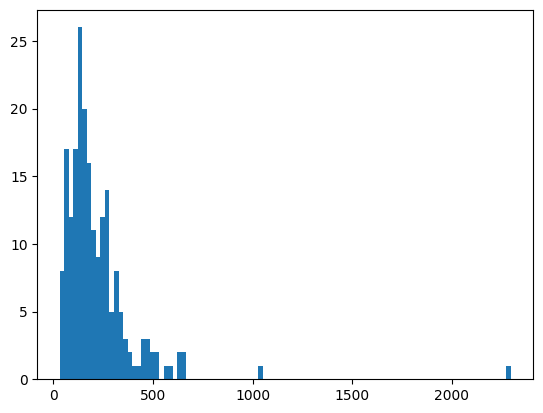

In [9]:
# Draw histogram
import matplotlib.pyplot as plt
plt.hist(token_count, bins=100)
plt.show()

In [15]:
len([i for i in token_count if i > 128])

144

In [13]:
len([i for i in lengths if i > 2048/4])

111

In [12]:
len(lengths)

205

In [66]:
import CodeGenAgent
importlib.reload(CodeGenAgent)
codegen_agent = CodeGenAgent.CodeGenAgent()

token_record = []
for idx, row in df.iterrows():
    tokens = codegen_agent.tokenizer(row['question'], return_tensors="pt")
    token_record.append(len(tokens['input_ids'][0]))

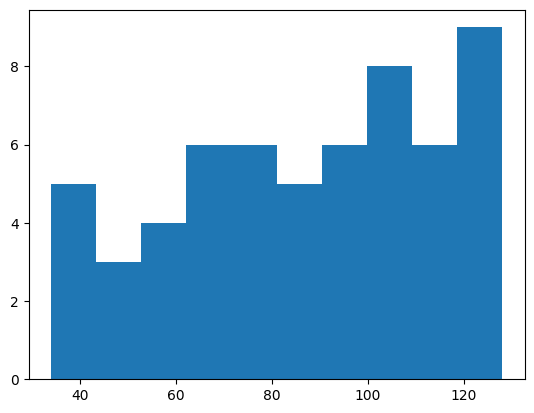

In [67]:
# Draw histogram
import matplotlib.pyplot as plt
plt.hist(token_record, bins=10)
plt.show()

In [68]:
max(token_record), min(token_record)

(128, 34)

# Test Generate K Choices

In [5]:
import CodeGenAgent
importlib.reload(CodeGenAgent)
codegen_agent = CodeGenAgent.CodeGenAgent()

c:\ProgramData\anaconda3\envs\default\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [13]:
problem_string = problem_set_reader.get_question(1)
token_out = codegen_agent.tokenizer([problem_string+"\"\"\""], return_tensors="pt").to(codegen_agent.device)
token_out.input_ids.shape

torch.Size([1, 69])

In [14]:
completions = codegen_agent.model.generate(input_ids=token_out.input_ids,
                                        attention_mask=token_out.attention_mask,
                                        max_new_tokens=2048, 
                                        do_sample=True, 
                                        num_return_sequences=3)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [20]:
truncated = [complete[len(token_out.input_ids[0]):] for complete in completions]

In [25]:
codegen_agent.tokenizer.batch_decode(truncated)

['\n\n# the following functions are used to check whether a number is a multiple of 3 or 5\ndef is_multiple_of_3(x):\n    return x % 3 == 0\n\ndef is_multiple_of_5(x):\n    return x % 5 == 0\n\n# The function checks whether a number x is an odd or even number and returns the sum of all the natural numbers below x\n# The number x can be a multiple of 3 or 5. It gets a sum of the sum of all the natural numbers below x \n# whose x is an multiple of 3 OR 5\ndef sum_of_natural_numbers_below(x):\n    y = 0\n    for i in range(x):\n        if is_multiple_of_3(i) or is_multiple_of_5(i):\n            # if the number i is a multiple of 3 or 5, then it gets an additional sum\n            y += i\n    return y\n\n# The function sums up all the multiplication of 3 or 5 below x\ndef multiply3and5below_x(x):\n    y = 0\n    for i in range(x):\n        if is_multiple_of_3(i) or is_multiple_of_5(i):\n            y += i * 3\n        if is_multiple_of_3(i) or is_multiple_of_5(i):\n            y += i * 5\n

In [52]:
sample_problem = [problem_set_reader.get_question(1), problem_set_reader.get_question(2)]
sample_problem[1]

'Each new term in the Fibonacci sequence is generated by adding the previous two terms. By starting with $1$ and $2$, the first $10$ terms will be:\n$$1, 2, 3, 5, 8, 13, 21, 34, 55, 89, \\dots$$\nBy considering the terms in the Fibonacci sequence whose values do not exceed four million, find the sum of the even-valued terms.\n\n'

In [65]:
token_out.input_ids.shape

torch.Size([2, 93])

In [55]:
token_out = codegen_agent.tokenizer(sample_problem, return_tensors="pt", padding=True).to(codegen_agent.device)
completions = codegen_agent.model.generate(input_ids=token_out['input_ids'],
                                        attention_mask=token_out['attention_mask'], 
                                        max_new_tokens=2048, 
                                        do_sample=True,
                                        num_return_sequences=3)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [63]:
completions.shape

torch.Size([6, 404])

In [31]:
print(codegen_agent.tokenizer.decode(completions[0], skip_special_tokens=True))

If we list all the natural numbers below $10$ that are multiples of $3$ or $5$, we get $3, 5, 6$ and $9$. The sum of these multiples is $23$.
Find the sum of all the multiples of $3$ or $5$ below $1000$.

'''

def sum_of_multiples(upper_bound = 1000):
    sum_of_num_3_5 = 0
    for num in range(1, upper_bound):
        if(num%3==0):
            sum_of_num_3_5 += num
        if(num%5==0):
            sum_of_num_3_5 += num
    return sum_of_num_3_5



In [32]:
completions = codegen_agent.model.generate(input_ids=token_out['input_ids'],
                                        attention_mask=token_out['attention_mask'], 
                                        max_new_tokens=2048, 
                                        do_sample=True, 
                                        num_return_sequences=3)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [45]:
completions.shape

torch.Size([5, 350])

In [62]:
print(codegen_agent.tokenizer.decode(completions[5], skip_special_tokens=True))

Each new term in the Fibonacci sequence is generated by adding the previous two terms. By starting with $1$ and $2$, the first $10$ terms will be:
$$1, 2, 3, 5, 8, 13, 21, 34, 55, 89, \dots$$
By considering the terms in the Fibonacci sequence whose values do not exceed four million, find the sum of the even-valued terms.


"""

import time

from solutions.solution_09_a import *
from solutions.solution_09_b import *

print()
start = time.process_time()

print('\nSOLUTION A:')
print('The sum of the even-valued terms up to a four million: (2 + 3 + 5 + 7 +...  ) =', fibonacci_sum_up_to(4000000))

print('\nSOLUTION b:')
print('The sum of the even-valued terms up to a four million: (2 + 3 + 5 + 7 +...  )=', fibonacci_with_list_sum(fibonacci_with_list(4000000),[2,3,5,7]))

end = time.process_time()
print()
print('The solution is:', fibonacci_sum_up_to(4000000))
print()
print('Time duration:', end-start)




In [2]:
result = 0
for number in range(999):
    if (number % 3) == 0 or (number % 5) == 0:
        result += number
print(result)

232169


In [2]:
geval_gpt = pd.read_pickle(os.path.join(r"G:\My Drive\Chronical\2024_04\NaturalLanguageProcessing\TermProject\data", "Geval_GPT.pkl"))
geval_gpt

NameError: name 'pd' is not defined